In [1]:
# load MDAnalysis library 
# to deal with GRO/XTC files
import MDAnalysis as mda
from MDAnalysis.analysis import align

# arrays
import numpy as np

# machine learning
from sklearn.decomposition import PCA, KernelPCA

# plotting
import matplotlib.pyplot as plt

In [2]:
# define path to structure files
PATHD = "../datasets/trajectories/"
FRAME = PATHD + "CLCec1_anton2_restrained_15us.gro"
TRAJ1 = PATHD + "CLCec1_anton2_restrained_15us.xtc"
TRAJ2 = PATHD + "CLCec1_anton2_unrestrain_15us.xtc"

# load traj files
trj = mda.Universe(FRAME,[TRAJ1,TRAJ2])

In [9]:
# fitting
#ref = mda.Universe(FRAME)
#fit = align.AlignTraj(trj, ref, select="protein and name CA", in_memory=True)
#fit.run()

In [10]:
# select only calpha carbons
protein = trj.select_atoms("name CA")

# get cartesian positions for traj1 and 2
trajCA = np.array([protein.positions for ts in trj.trajectory])

In [11]:
# scikit-learn expects 2d numpy arrays
# for the training dataset
frames, atoms, dimensions = trajCA.shape
# change dimensions
dataset = trajCA.reshape((frames,atoms*dimensions))

# get PCA projection 
pca = PCA(n_components=2)
vec = pca.fit(dataset).transform(dataset)

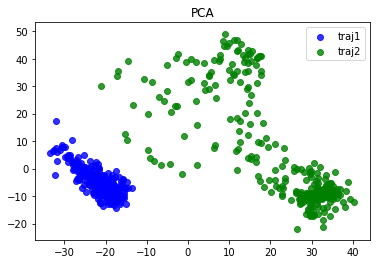

In [12]:
# plot
plt.scatter(vec[:300,0], vec[:300,1], color='blue',  alpha=.8, label='traj1')
plt.scatter(vec[300:,0], vec[300:,1], color='green', alpha=.8, label='traj2')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA')
plt.show()

In [13]:
kpca = KernelPCA(kernel="cosine", fit_inverse_transform=True, gamma=10)
X_kpca = kpca.fit_transform(dataset)

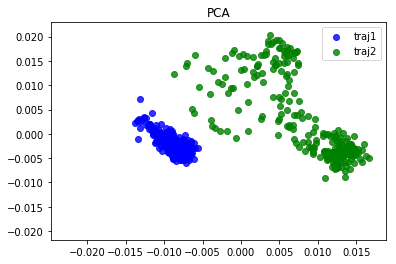

In [14]:
# plot
plt.scatter(X_kpca[:300,0], X_kpca[:300,1], color='blue',  alpha=.8, label='traj1')
plt.scatter(X_kpca[300:,0], X_kpca[300:,1], color='green', alpha=.8, label='traj2')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA')
plt.show()